# Линейная регрессия: аналитическое решение

### АНАЛИТИЧЕСКОЕ РЕШЕНИЕ С ПОМОЩЬЮ NUMPY

Вот какие этапы нам предстоит пройти, чтобы построить свою модель:

* Загрузить данные и проанализировать датасет на предмет пропусков.
* Подготовить данные для подачи в модель: избавиться от пропусков, если они есть, и перекодировать категориальные признаки, если они представлены текстом.
* Построить модель. Будем строить несколько моделей линейной регрессии: первую — на одном признаке, вторую — на всех доступные признаках.
* Оценить качество модели.

Для начала импортируем необходимые вспомогательные библиотеки:

In [4]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
%matplotlib inline
plt.style.use('seaborn') #установка стиля matplotlib

C:\Users\jkons\AppData\Local\Temp\ipykernel_15340\546158159.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #установка стиля matplotlib


Будем работать с датасетом из библиотеки sklearn о домах в Бостоне. Этот набор данных содержит информацию, собранную службой переписи населения США и касающуюся жилья в районе Бостона, штат Массачусетс.

Данный датасет содержится в модуле datasets библиотеки sklearn. Давайте загрузим датасет с помощью функции load_boston() и выведем его описание, обратившись по ключу 'DESCR':

In [6]:
column_names = [
    'CRIM',    # уровень преступности на душу населения по городам
    'ZN',      # доля земли под жилую застройку, разделённая на участки площадью более 25 000 кв. футов
    'INDUS',   # доля акров, которые принадлежат предприятиям, не связанным с розничной торговлей, на город
    'CHAS',    # фиктивная переменная реки Чарльз (1 — если участок прилегает к реке; 0 — в противном случае)
    'NOX',     # концентрация оксидов азота (в десятимиллионных долях)
    'RM',      # среднее количество комнат в доме
    'AGE',     # доля зданий, построенных до 1940 г. и занимаемых владельцами
    'DIS',     # взвешенные расстояния до пяти бостонских центров занятости
    'RAD',     # индекс доступности радиальных автомобильных дорог
    'TAX',     # полная ставка налога на имущество за каждые 10 000 долларов стоимости
    'PTRATIO', # соотношение учеников и учителей по городам
    'B',       # 1000 * (Bk — 0.63), где Bk — доля граждан афроамериканского происхождения по городам
    'LSTAT',   # процент населения с низким статусом
    'MEDV'     # медианное значение стоимости домов, занимаемых владельцами, в тысячах долларов США (целевой признак)
]
boston_data = pd.read_csv('data/housing.csv', header=None, delimiter=r"\s+", names=column_names)
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Выведем информацию о таблице boston_data с помощью метода info():

In [7]:
boston_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


*Примечание. Модель линейной регрессии требует, чтобы в подаваемых ей на вход данных не было пропущенных значений. Поэтому если в ваших данных окажутся пропуски, обязательно заранее позаботьтесь о них.*

Итак, в наших данных нет пропусков, а значит их можно подавать в модель, чтобы обучить её предсказывать целевой признак (признак MEDV).

*Также модель не умеет работать с категориальными признаками, представленными в виде типа object. Прежде чем подавать в модель линейной регрессии категориальные признаки, необходимо произвести кодировку категорий с помощью уже знакомых вам методов кодирования.*

→ Давайте начнём с простого. Построим линейную регрессию на одном признаке. Выберем признак, который имеет наиболее высокую линейную взаимосвязь. Для этого рассчитаем корреляцию признаков с целевой переменной и выберем наиболее влиятельный.

Для лучшего восприятия давайте построим столбчатую диаграмму для модульного значения корреляций:

*Примечание. Мы могли визуализировать матрицу корреляций, однако сейчас нас интересует только связь факторов с целевым признаком, поэтому нагляднее будет воспользоваться столбчатой диаграммой.*

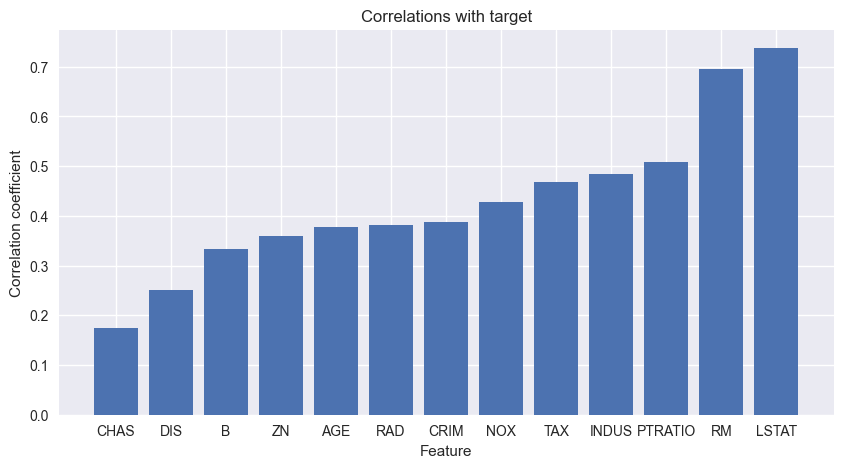

In [8]:
#Вычисляем модуль корреляции
corr_with_target = boston_data.corr()['MEDV'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('MEDV')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

Итак, самый коррелированный по модулю с медианной ценой (MEDV) признак — процент населения с низким статусом (LSTAT). Давайте построим линейную регрессию, используя этот признак.

*Примечание. Построить линейную регрессию = обучить линейную регрессию = найти её параметры.*

Вспоминаем нашу формулу аналитического решения по методу наименьших квадратов:

![метод наименьших квадратов](img/form_met_naim_kv.png)

Что есть X и y? Это матрица из примеров (матрица наблюдений) и вектор правильных ответов к ним соответственно. У нас матрица X — это таблица, состоящая из одного столбца (LSTAT), а y — столбец с медианными ценами (MEDV):

In [9]:
X = boston_data[['LSTAT']] #матрица наблюдений
y = boston_data['MEDV'] #вектор правильных ответов
X.head()
#y.head()

,LSTAT
0,4.98
1,9.14
2,4.03
3,2.94
4,5.33


*Примечание. Двойные квадратные скобки **boston_data[['LSTAT']]** позволяют выбрать признак из DataFrame, сохранив его в виде таблицы. Это важно, так как в формуле МНК X — это матрица.*

У нас есть все компоненты формулы, чтобы найти параметры модели. Давайте напишем функцию *linear_regression()*, в которой реализуем вычисления коэффициентов. Аргументами функции будут матрица наблюдений X и вектор ответов y, а возвращать она будет вектор параметров w.

Матричные вычисления легче всего реализовать через библиотеку numpy.

Для начала вспомним, что для вычисления свободного члена W0 необходимо добавить в таблицу столбец, полностью состоящий из единиц. Такой столбец можно создать с помощью знакомой нам функции ones() из библиотеки numpy, а присоединить его к таблице X поможет функция column_stack().

Матричное умножение в numpy реализуется с помощью оператора @. Транспонирование осуществляется через .T, а обратная матрица вычисляется с помощью функции *inv()* из модуля *linalg* (модуля для линейной алгебры).

In [10]:
def linear_regression(X, y):
    #Создаём вектор из единиц
    ones = np.ones(X.shape[0])
    #Добавляем вектор к таблице первым столбцом
    X = np.column_stack([ones, X])
    #Вычисляем обратную матрицу Q
    Q = np.linalg.inv(X.T @ X)
    #Вычисляем вектор коэффициентов
    w = Q @ X.T @ y
    return w

Осталось только вызвать нашу функцию и передать в неё нашу таблицу примеров X и столбец правильных ответов y. Вычислим вектор параметров и выведем его на экран:

In [11]:
#Вычисляем параметры линейной регрессии
w = linear_regression(X, y)
#Выводим вычисленные значения параметров в виде вектора
print('Vector w: {}'.format(w))
#Выводим параметры с точностью до двух знаков после запятой
print('w0: {:.2f}'.format(w[0]))
print('w1: {:.2f}'.format(w[1]))
# Vector w: [34.55384088 -0.95004935]
# w0: 34.55
# w1: -0.95

Vector w: [34.55384088 -0.95004935]
w0: 34.55
w1: -0.95


Итак, мы получили значения коэффициентов уравнения прямой. С точностью до сотых они равны:

![form_lin_regr](img/form_lin_regr.png)

Самое приятное в модели линейной регрессии — то, что её коэффициенты можно проинтерпретировать. 

Коэффициент  W0=34.55 имитирует влияние сторонних факторов, которые не учтены в модели. Это значение медианной цены домов на участке, если бы значение процента населения с низким статусом было равно 0. 

Коэффициент  W1=-0.95 означает, на сколько в среднем изменится медианная цена (в тысячах долларов) при увеличении низкостатусного населения на 1 единицу. То есть если количество низкостатусного населения увеличится на 1 %, то медианная цена зданий на участке упадёт на 0.95 тысяч долларов. Можно сказать, что каждый новый процент низкостатусного населения уменьшает медианную цену на 0.95 тысяч долларов.

Теперь, если в данных появится новый участок Бостона с известной долей низкостатусного населения, мы сможем предсказать значение медианной стоимости домов простой подстановкой значений в модель:

In [13]:
#Задаём процент низкостатусного населения
x_example = 5.18 
#Делаем предсказание
y_predict = w[0] + w[1] * x_example
print('Predicted value: {:.2f}'.format(float(y_predict)))
#Predicted value: 29.63

Predicted value: 29.63


Так как мы работаем с одним фактором, то можем построить визуализацию нашей модели.

Давайте напишем функцию plot_regression_2d(), у которой будет три обязательных аргумента (матрица наблюдений X, столбец правильных ответов y и столбец с предсказаниями модели y_pred) и два аргумента по умолчанию (xlabel — подпись оси абсцисс и ylabel — подпись оси ординат).

In [14]:
def plot_regression_2d(X, y_true, y_predict, xlabel='LSTAT', ylabel='MEDV'):
    fig, ax = plt.subplots(figsize=(8, 4)) #фигура + координатная плоскость
    ax.scatter(X, y_true, alpha=0.7, label='Sample data') #диаграмма рассеяния
    ax.plot(X, y_predict, color='black', label='Regression model') #линейный график
    ax.set_xlabel(xlabel) #название оси абсцисс
    ax.set_ylabel(ylabel) #название оси ординат
    ax.legend(facecolor='white', fontsize=11) #легенда

Сделаем предсказание для всех объектов из таблицы X, подставив её в модель линейной регрессии с найденными параметрами, и построим график:

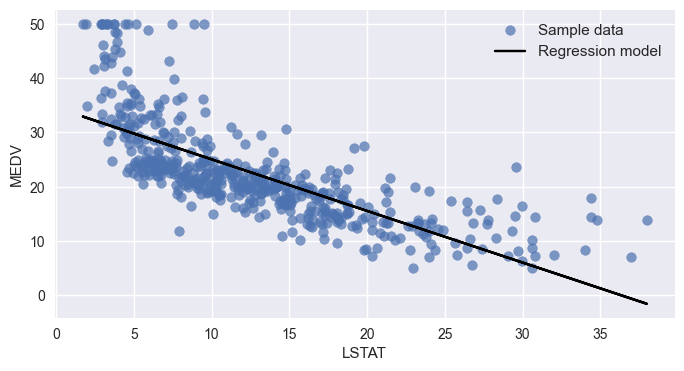

In [15]:
#Делаем предсказание для всех объектов из таблицы
y_predict = w[0] + w[1] * X
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

Как и ожидалось, прямая является убывающей (коэффициент  W1<0), и, если её продолжить влево, она пересечётся с осью ординат в точке W0=34.55. 

*Итак, мы воспользовались формулой для МНК алгоритма и нашли параметры модели линейной регрессии «вручную», реализовав формулу в виде функции. Отметим, что наша функция универсальна: в неё можно подавать не только матрицу X с одним признаком (LSTAT), но и таблицу, содержащую все признаки, описывающие участки.*

*Конечно же, никто не строит линейную регрессию «руками», используя формулу МНК. Все дата-сайентисты пользуются библиотеками, такими как sklearn. Давайте посмотрим на реализацию ↓*

### АНАЛИТИЧЕСКОЕ РЕШЕНИЕ С ПОМОЩЬЮ SKLEARN

Алгоритм построения модели реализован в библиотеке машинного обучения sklearn и находится в модуле linear_model. Давайте импортируем этот модуль:

In [16]:
from sklearn import linear_model

В модуле находится класс LinearRegression, который реализует аналитическое решение линейной регрессии. Для обучения модели необходимо просто вызвать метод fit(), передав в него матрицу наблюдений X и вектор правильных ответов y.

Данный метод реализует формулу метода наименьших квадратов и рассчитает параметры модели самостоятельно. Чтобы получить свободный член W0 нужно обратиться по атрибуту intercept_, а вектор параметров  W1,W2,W3,...,Wm будет храниться в атрибуте coef_ (так как у нас один фактор в матрице X, то и коэффициент будет только один):

In [17]:
#Создаём объект класса LinearRegression
lr_lstat = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_lstat.fit(X, y)
 
print('w0: {}'.format(lr_lstat.intercept_)) #свободный член w0
print('w1: {}'.format(lr_lstat.coef_)) #остальные параметры модели w1, w2, ..., wm
 
# w0: 34.55384087938311
# w1: [-0.95004935]

w0: 34.5538408793831
w1: [-0.95004935]


*Примечание. Обратите внимание, что мы получили ровно те же самые значения для параметров модели, что является вполне ожидаемым, ведь метод fit() у объекта LinearRegression реализует ту же самую формулу МНК, которую мы прописали в функции linear_regression(). Интерпретация коэффициентов остаётся той же.*

Модель обучена. А как сделать предсказание? Вручную записывать выражение для модели и подставлять коэффициенты? Конечно же, нет. Для этого есть метод predict(). В него необходимо передать матрицу наблюдений, для которых нужно сделать предсказание.

Давайте сделаем предсказание для всех наших наблюдений из таблицы X и визуализируем результат с помощью нашей функции plot_regression_2d():

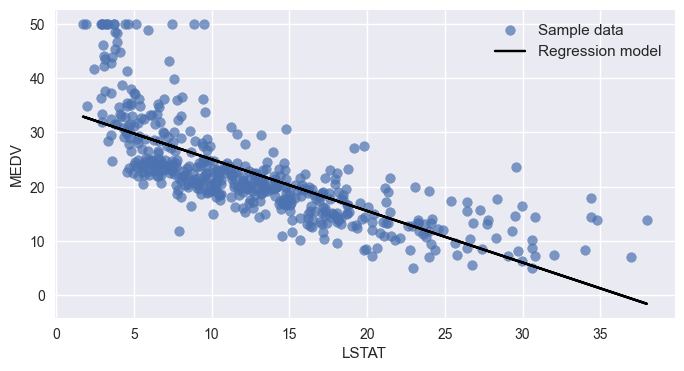

In [18]:
#Предсказываем медианную цену для всех участков из набора данных
y_predict = lr_lstat.predict(X)
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

Получаем тот же самый график, что мы видели ранее, когда реализовывали линейную регрессию вручную.

А что, если мы хотим построить линейную регрессию, используя всю предоставленную информацию, то есть все 13 признаков? Не проблема! Нужно только расширить матрицу наблюдений X, добавив в неё остальные признаки и снова обучить модель LinearRegression.

Давайте выберем из таблицы boston все столбцы, исключая столбец с целевой переменной (MEDV). Полученную матрицу X и вектор правильных ответов y отправляем в метод fit(), чтобы произвести подгонку и найти параметры модели.

In [19]:
#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']
#Создаём объект класса LinearRegression
lr_full = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_full.fit(X, y)

LinearRegression()

Для удобства составим DataFrame из коэффициентов W1,W2,...,W13  обученной модели, не забыв добавить к нему строку со свободным членом W0:

In [20]:
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': lr_full .coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr_full .intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,-0.108011
1,ZN,0.046420
2,INDUS,0.020559
3,CHAS,2.686734
4,NOX,-17.766611
5,RM,3.809865
6,AGE,0.000692
7,DIS,-1.475567
8,RAD,0.306049
9,TAX,-0.012335


Итак, мы получили таблицу с признаками из нашего набора данных и коэффициентами, которые им соответствуют.

Каждый из коэффициентов в модели показывает, на сколько в среднем (согласно модели) изменится медианная цена (в тысячах долларов) при увеличении параметра на единицу. Например, если уровень преступности увеличится на один пункт, то медианная цена зданий на участке упадёт на 0.1 тыс. долларов. А вот увеличение среднего количества комнат на участке (RM) на одну единицу повысит медианную цену на 3.8 тыс. долларов.

*→ Свободный член (INTERCEPT) всё так же имитирует влияние внешних факторов и носит смысл «поправки» модели относительно медианной стоимости.*

Итак, мы с вами построили две модели линейной регрессии: lr_lstat на одном признаке (LSTAT) и lr_full — на всех признаках в данных. Хотелось бы сравнить эти модели по их качеству. Может, нам достаточно только знаний о проценте низкостатусного населения, чтобы предсказать медианную цену?

Самая простая идея — визуализировать ошибки. Давайте построим коробчатые диаграммы ошибок моделей. Ошибки будем считать по формуле:

![form_error](img/form_error.png)

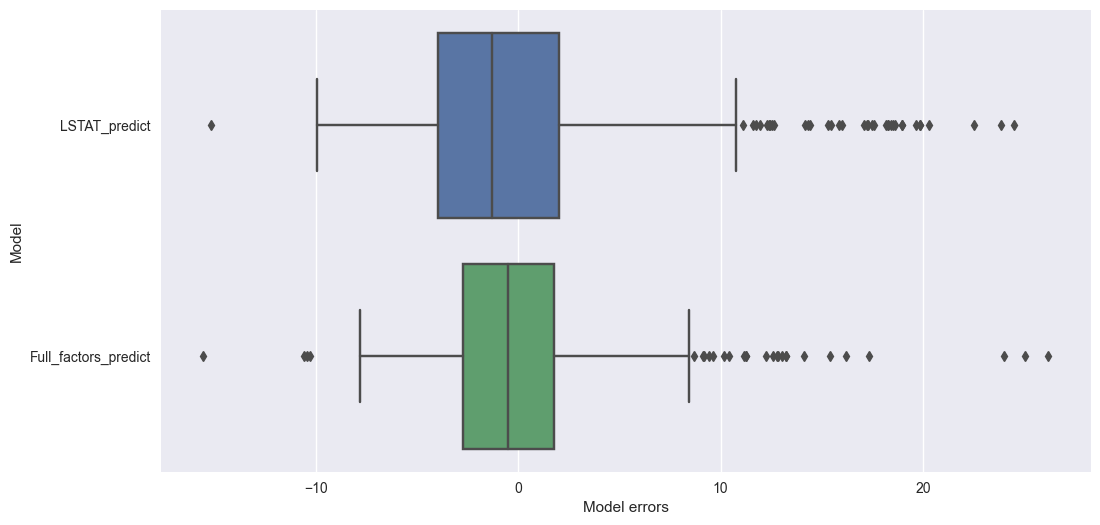

In [21]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели на одном факторе LSTAT
y_errors_lstat = y - lr_lstat.predict(boston_data[['LSTAT']])
#Ошибки модели на всех факторах
y_errors_full = y - lr_full.predict(boston_data[features])
#Для удобства визуализации составим DataFrame из ошибок
errors_df = pd.DataFrame(
    {'LSTAT_predict': y_errors_lstat, 
     'Full_factors_predict': y_errors_full
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

*Из построенных диаграмм ошибок видно, что разброс ошибок для модели, построенной на всех признаках, ниже (ящик уже и усы короче), и медиана ошибки также более приближена к 0. То есть можно сказать, что визуально качество второй модели выглядит лучше.*

*На обеих диаграммах присутствуют точки, сильно выбивающиеся за пределы усов. Это наблюдения, для которых модель допустила очень большую ошибку, по сравнению с основной группой.*

*Можно предположить, что это объекты, для которых гипотеза о линейной зависимости несправедлива, и линейной модели не хватает для предсказания целевой переменной для таких объектов. О том, как справиться с этой проблемой, мы поговорим чуть позже.*

Визуализация — это, конечно, хорошо, но, согласитесь, не очень удобно: визуализация не даёт конкретики — только общие представления об ошибках.

Может быть, есть способ описать качество модели каким-то конкретным числом? Да. Этот показатель называется метрикой. 

#### Задание 2.7

В данных появился новый участок со следующими параметрами:
```
CRIM         0.35114
ZN           0.00000
INDUS        7.38000
CHAS         0.00000
NOX          0.49300
RM           6.04100
AGE         49.90000
DIS          4.72110
RAD          5.00000
TAX        287.00000
PTRATIO     19.60000
B          396.90000
LSTAT        7.70000
```
Сделать предсказание медианной стоимости (MEDV) для данного участка c помощью модели lr_full. Результат предсказания в тысячах долларов. Ответ округлить до второго знака после точки-разделителя.

In [22]:
# display(lr_full.predict(X))
new_dict = {
    'CRIM': [0.35114],
    'ZN': [0],
    'INDUS': [7.38000],
    'CHAS': [0],
    'NOX': [0.49300],
    'RM': [6.04100],
    'AGE': [49.90000],
    'DIS': [4.72110],
    'RAD': [5],
    'TAX': [287.00000],
    'PTRATIO': [19.60000],
    'B': [396.90000],
    'LSTAT': [7.70000],
}
X_new = pd.DataFrame(new_dict)
display(X_new)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.35114,0,7.38,0,0.493,6.041,49.9,4.7211,5,287.0,19.6,396.9,7.7


In [23]:
print(round(lr_full.predict(X_new)[0], 2))

22.87


#### Задание 2.8
Дан набор данных о стартапах и их прибыли (в долларах) в трёх различных штатах США.

Столбцы:

- **`R&D Spend`**&nbsp;&mdash; расходы на исследования.
- **`Administration`**&nbsp;&mdash; административные расходы.
- **`Marketing Spend`**&nbsp;&mdash; расходы на маркетинг.
- **`State*`**&nbsp;&mdash; штат.
- **`Profit`**&nbsp;&mdash; прибыль (целевой признак).

Для обучения линейной регрессии использовать `R&D Spend`, `Administration` и `Marketing Spend`. Отделить факторы от целевой переменной.

Обучить модель линейной регрессии методом наименьших квадратов с помощью библиотеки **`numpy`** (воспользоваться формулой из модуля).

Чему равны коэффициенты линейной регрессии при признаках `R&D Spend`, `Administration` и `Marketing Spend`? Ответ ввести с точностью до второго знака после точки-разделителя.

In [24]:
start_df = pd.read_csv('data/50_Startups.csv')
start_df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [25]:
start_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [26]:
X = start_df[['R&D Spend', 'Administration', 'Marketing Spend']]
y = start_df['Profit']
w = linear_regression(X, y)
print(f'Intercept factor: {round(w[0], 2)}')
print(f'R&D factor: {round(w[1], 2)}')
print(f'Admin factor: {round(w[2], 2)}')
print(f'Marketing factor: {round(w[3], 2)}')

Intercept factor: 50122.19
R&D factor: 0.81
Admin factor: -0.03
Marketing factor: 0.03


#### Метрики регрессии. Недостатки аналитического решения

РАСЧЁТ МЕТРИК НА PYTHON


Настало время проверить качество построенных нами ранее моделей линейной регрессии: lr_lstat и lr_full.

Весь набор функций для вычисления метрик в sklearn находится в модуле metrics. Давайте его импортируем:

In [27]:
from sklearn import metrics

Функции, которые нам понадобятся:

* mean_absolute_error() — расчёт MAE;
* mean_squared_error() — расчёт MSE;
* mean_absolute_percentage_error() — расчёт MAPE;
* r2_score() — расчёт коэффициента детерминации .

В каждую из функций достаточно передать правильные ответы и предсказания, и функция вернёт рассчитанную метрику.

*Примечание. Для расчёта метрики RMSE нет специальной функции, однако мы знаем, что для её расчёта достаточно извлечь квадратный корень из MSE.*

*Из-за особенностей реализации функция mean_absolute_percentage_error() возвращает результат не в процентах, а в долях. Чтобы отобразить результат в процентах, необходимо умножить его на 100.*

Давайте вычислим метрики и выведем их на экран, округлив до третьего знака после запятой. Начнём с модели lr_lstat: сделаем предсказание на основании признака LSTAT и передадим истинные и предсказанные медианные цены в функции для расчёта метрик:

In [29]:
y = boston_data.MEDV
#Делаем предсказание по признаку LSTAT
y_predict_lstat = lr_lstat.predict(boston_data[['LSTAT']])
#Рассчитываем MAE
print('MAE score: {:.3f} thou. $'.format(metrics.mean_absolute_error(y, y_predict_lstat)))
#Рассчитываем RMSE
print('RMSE score: {:.3f} thou. $'.format(np.sqrt(metrics.mean_squared_error(y, y_predict_lstat))))
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_predict_lstat) * 100))
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict_lstat)))
 
 
# MAE score: 4.505 thou. $
# RMSE score: 6.203 thou. $
# MAPE score: 21.352 %
# R2 score: 0.544

MAE score: 4.505 thou. $
RMSE score: 6.203 thou. $
MAPE score: 21.352 %
R2 score: 0.544


Проделываем ту же самую операцию для второй модели линейной регрессии, lr_full:

In [30]:
#Делаем предсказание по всем признакам
y_predict_full = lr_full.predict(boston_data[features])
#Рассчитываем MAE
print('MAE score: {:.3f} thou. $'.format(metrics.mean_absolute_error(y, y_predict_full)))
#Рассчитываем RMSE
print('RMSE score: {:.3f} thou. $'.format(np.sqrt(metrics.mean_squared_error(y, y_predict_full))))
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_predict_full) * 100))
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict_full)))
 

# MAE score: 3.271 thou. $
# RMSE score: 4.679 thou. $
# MAPE score: 16.417 %
# R2 score: 0.741

MAE score: 3.271 thou. $
RMSE score: 4.679 thou. $
MAPE score: 16.417 %
R2 score: 0.741


Сравним полученные результаты:

* MAE : в среднем первая модель ошибается на  4.505 тыс. долларов, а вторая — на 3.271 тыс. долларов.
* RMSE : среднеквадратичное отклонение первой модели от истинных ответов составляет 6.203 тыс. долларов, а второй — 4.679.
* MAPE : первая модель ошибается на 21.352 %, а вторая — на 16.417 %.
* R2 : доля объясняемой информации (дисперсии), которую улавливает первая модель, — 0.544, а вторая — 0.741.

Очевидно, что по всем метрикам вторая модель, построенная на основе всех признаков в данных, превосходит первую.

#### Задание 3.2

Есть истинные ответы y_true = [1.23, 2.35, 2.75] и предсказания модели y_pred = [1.01, 12.3, 2.74]. Посчитать метрику RMSE, ответ округлить до двух знаков после точки-разделителя.

In [31]:
y_true = [1.23, 2.35, 2.75]
y_pred = [1.01, 12.3, 2.74]
print(f'RMSE score: {np.sqrt(metrics.mean_squared_error(y_true, y_pred)):.2f}')

RMSE score: 5.75


#### Задание 3.3

Чему равен коэффициент детерминации на следующих данных?

Истинные ответы: y_true = [22.4, 20.6, 23.9, 22.0, 11.9]

Предсказанные ответы: y_pred = [20.5, 20.2, 20.3, 19.0, 11.0]

Ответ округлить до двух знаков после точки-разделителя.

In [32]:
y_true = [22.4, 20.6, 23.9, 22.0, 11.9]
y_pred = [20.5, 20.2, 20.3, 19.0, 11.0]
print(f'R2 score: {metrics.r2_score(y_true, y_pred):.2f}')

R2 score: 0.71


### Линейная регрессия: численное решение

Как и раньше, будем работать с датасетом о домах в Бостоне из библиотеки sklearn.

In [34]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Обучим с помощью градиентного спуска линейную регрессию на одном факторе — LSTAT (процент низкостатусного населения) — и сравним результат с полученным ранее результатом МНК.

In [35]:
X = boston_data[['LSTAT']] #матрица наблюдений
y = boston_data['MEDV'] #вектор правильных ответов

Будем использовать реализацию стохастического градиентного спуска для линейной регрессии из библиотеки sklearn — SGDRegressor. Она находится в том же модуле linear_model.

У класса SGDRegressor есть множество параметров. Например, параметр random_state отвечает за число, на основе которого происходит генерация  случайных чисел. Напомним, в SGD случайность присутствует в инициализации параметров и выборе части из набора данных. Установив значение параметра random_state равным определённому числу, мы можем гарантировать одинаковые результаты работы метода при разных запусках. Пусть это будет число 42.

Для обучения используется метод fit(): он запускает работу градиентного спуска для поиска параметров, в него необходимо передать данные и правильные ответы.

*Примечание. К сожалению, в sklearn нельзя посмотреть то, как происходит поиск оптимальных параметров с помощью SGD. Поэтому нет возможности продемонстрировать историю изменения функции потерь. В модулях по оптимизации мы самостоятельно реализуем алгоритм и посмотрим на поэтапную минимизацию.*

In [36]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_lstat = linear_model.SGDRegressor(random_state=42)
#Обучаем модель — ищем параметры по методу SGD
sgd_lr_lstat.fit(X, y)

SGDRegressor(random_state=42)

Обучение завершено, параметры найдены. Давайте выведем их на экран. Для этого используются уже знакомые вам атрибуты coef_ и intercept_:

In [37]:
print('w0: {}'.format(sgd_lr_lstat.intercept_)) #свободный член w0
print('w1: {}'.format(sgd_lr_lstat.coef_)) #остальные параметры модели w1, w2, ..., wm

# w0: [34.33010969]
# w1: [-0.96193242]

w0: [34.33010969]
w1: [-0.96193242]


Примечание. Обратите внимание, что значения параметров немного отличаются от полученных ранее с помощью МНК значений. Для МНК коэффициенты были равны:

* w0: [34.55384087938311]
* w1: [-0.95004935]

В этом нет ничего удивительного, ведь МНК — это аналитический метод, он выдаёт точное решение, а SGD — численный, и вычисления останавливаются, когда достигается приемлемая точность.

Давайте с помощью метода predict() сделаем предсказание цены для всех объектов из нашей выборки и построим визуализацию:

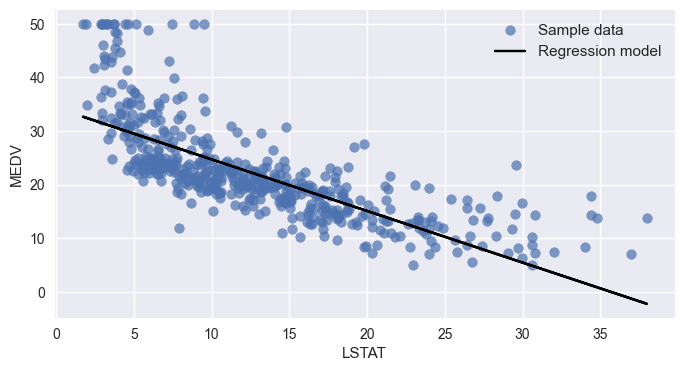

In [38]:
#функция для визуализации регрессии
def plot_regression_2d(X, y_true, y_predict, xlabel='LSTAT', ylabel='MEDV'):
    fig, ax = plt.subplots(figsize=(8, 4)) #фигура + координатная плоскость
    ax.scatter(X, y_true, alpha=0.7, label='Sample data') #диаграмма рассеяния
    ax.plot(X, y_predict, color='black', label='Regression model') #линейный график
    ax.set_xlabel(xlabel) #название оси абсцисс
    ax.set_ylabel(ylabel) #название оси ординат
    ax.legend(facecolor='white', fontsize=11) #легенда
#Предсказываем медианную цену для всех участков из набора данных
y_predict = sgd_lr_lstat.predict(X)
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

Можно рассчитать метрики регрессии для полученной модели. Давайте для примера посчитаем R2:

In [39]:
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))
# R2 score: 0.542

R2 score: 0.542


Итоговый R2 для линейной регрессии, обученной с помощью градиентного спуска, составил 0.542. Напомним, для той же модели, обученной с помощью МНК, метрика была равна 0.544. То есть доля информации, которую объяснила модель, обученная с помощью градиентного спуска, ниже примерно на 0.002. Очевидно, в реальных задачах такая разница не имеет значения. 

Теперь попробуем обучить многомерную линейную регрессию с помощью SGD. Как и раньше составим полную матрицу наблюдений  из всех факторов, которые нам даны. Обучим модель и выведем значения коэффициентов в виде DataFrame:

In [40]:
#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']
 
#Создаём объект класса линейной регрессии с SGD
sgd_lr_full = linear_model.SGDRegressor(random_state=42)
#Обучаем модель — ищем параметры по методу SGD
sgd_lr_full.fit(X, y)
 
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': sgd_lr_full.coef_})
#Составляем строчку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': sgd_lr_full.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,2.156857e+11
1,ZN,1.248446e+10
2,INDUS,7.277644e+09
3,CHAS,8.306154e+09
4,NOX,-8.413828e+09
5,RM,-3.148182e+10
6,AGE,8.685820e+10
7,DIS,-2.256141e+11
8,RAD,-4.683208e+10
9,TAX,1.892286e+09


Все коэффициенты имеют запредельные значения (9-11 степени числа 10). Это типичная картина расходящегося градиентного спуска: алгоритм не достиг точки минимума по каким-то причинам. Такие высокие значения коэффициентов означают, что модель является неустойчивой.

Давайте сделаем предсказание и выведем R2 для обученной модели:

In [41]:
#Предсказываем медианную цену для всех участков из набора данных
y_predict = sgd_lr_full.predict(X)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

# R2 score: -10590303862129977211224064.000

R2 score: -10590303862129979358707712.000


R2 отрицательный. Да ещё какой! Напомним, отрицательный  R2 говорит о том, что модель абсолютно не описывает зависимости в данных.

В чём же причина? Неужели SGD не справился с поиском 14 параметров (свободный член + 13 коэффициентов при факторах)?

*→ Ответ очень простой — отсутствие масштабирования. Как мы уже говорили ранее, при использовании градиентного спуска и его модификаций очень важно масштабировать данные с помощью нормализации или стандартизации. Иначе алгоритм теряется в таком растянутом пространстве из-за неравномерных градиентов.*

Давайте стандартизируем наши данные. Воспользуемся классом StandardScaler из модуля preprocessing библиотеки sklearn, который реализует стандартизацию.

In [42]:
from sklearn import preprocessing
 
#Инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()
#Производим стандартизацию
X_scaled = scaler.fit_transform(X)
#Составляем DataFrame из результата
X_scaled = pd.DataFrame(X_scaled, columns=features)
X_scaled.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501


Попытка №2. Обучим модель и составим таблицу из её параметров:

In [46]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_full = linear_model.SGDRegressor(random_state=42)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_full.fit(X_scaled, y)
 
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': sgd_lr_full.coef_})
#Составляем строчку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': sgd_lr_full.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,-0.870552
1,ZN,0.947112
2,INDUS,-0.116802
3,CHAS,0.730289
4,NOX,-1.894276
5,RM,2.757578
6,AGE,-0.027846
7,DIS,-3.049237
8,RAD,1.957066
9,TAX,-1.305271


Вот теперь результат более схож с реальностью. Сделаем предсказание и посчитаем результирующий :

In [47]:
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_full.predict(X_scaled)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

# R2 score: 0.740

R2 score: 0.740


Теперь метрика имеет приемлемое значение, а значит градиентный спуск смог сойтись.

*Важно! Если вы обучили модель на стандартизованных данных, то и для предсказания необходимо передавать их в стандартизованном виде.*

Например, если попытаться сделать предсказание с помощью построенной модели, передав в качестве матрицы наблюдений нестандартизованную таблицу, то ошибки мы не получим, однако значение метрики будет неадекватным:

In [48]:
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_full.predict(X)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

# R2 score: -1856.503

R2 score: -1856.503


![Param_SGDregr](img/param_SGDreg.png)

Давайте посмотрим, что будет, если выставить константный режим управления темпом обучения и задать ему более высокое значение, например 0.1:

In [49]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_bad = linear_model.SGDRegressor(
    learning_rate='constant', #режим темпа обучения — константа
    eta0=0.1, #начальное и постоянное значение темпа обучения
    random_state=42
)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_bad.fit(X_scaled, y)
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_bad.predict(X_scaled)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

#R2 score: -335415038359.635

R2 score: -335415038359.635


R2<0, то есть SGD разошёлся из-за слишком высокого темпа обучения. 

Вот ещё один плохой пример. Что будет, если поставить слишком маленькое значение параметра eta0? Например, 0.000001.

In [50]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_bad2 = linear_model.SGDRegressor(
    learning_rate='constant', #режим темпа обучения — константа
    eta0=1e-6, #начальное и постоянное значение темпа обучения
    random_state=42
)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_bad2.fit(X_scaled, y)
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_bad2.predict(X_scaled)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))
 
# R2 score: -1.578
# warnings.warn("Maximum number of iteration reached before ")

R2 score: -1.578


c:\Users\jkons\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Снова R2<0, но также мы видим предупреждение (warning), которое говорит о том, что алгоритму не хватило количества итераций (max_iter), чтобы добраться до минимума. То есть SGD не дошёл до точки минимума из-за слишком низкого темпа обучения.

*→ Так как модель линейной регрессии является довольно простой и исследованной, то значения параметров, которые обладают наибольшей эффективностью, уже установлены по умолчанию (аргументы по умолчанию), но бывают ситуации, когда поэкспериментировать с параметрами может быть полезно, чтобы попытаться повысить качество.*

#### Задание 4.9

Найдите в документации параметр `tol`, отвечающий на критерий остановки (по умолчанию он равен 0.001).

Обучить `SGDRegressor` на датасете о домах в Бостоне с параметром остановки, равным 0.1, и `random_state`=42. Остальные параметры оставить по умолчанию.

Рассчитать коэффициент детерминации $R^2$. Ответ округлить до третьего знака после точки-разделителя.

In [51]:
sgd_lr_tol = linear_model.SGDRegressor(tol=0.1, random_state=42)
sgd_lr_tol.fit(X_scaled, y)
y_predict_tol = sgd_lr_tol.predict(X_scaled)
print(f'R2 score: {metrics.r2_score(y, y_predict_tol):.3f}')

R2 score: 0.735


![Metods_OLS_SGDR](img/metods_lin_SGDR.png)